# Github Performance Metrics- Issues

**Activity by Repo**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
import warnings
warnings.filterwarnings('ignore')

with open("../../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['move2kube']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[30740]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

## Query for Issue Analysis

In [5]:
df_issues = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					i.issue_id AS issue, 
					i.gh_issue_number AS issue_number,
					i.gh_issue_id AS gh_issue,
					i.created_at AS created, 
					i.closed_at AS closed
                FROM
                	repo r,
                    issues i
                WHERE
                	r.repo_id = i.repo_id AND
                    i.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues = pd.concat([df_issues, df_current_repo])

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)
        
df_issues.head()

,repo_name,issue,issue_number,gh_issue,created,closed
0,move2kube,67723,618,1041980874,2021-11-02 07:53:32,NaT
1,move2kube,67727,614,1040065240,2021-10-30 06:19:04,NaT
2,move2kube,67736,605,1027334450,2021-10-15 11:06:30,NaT
3,move2kube,67737,604,1027329217,2021-10-15 10:59:35,NaT
4,move2kube,67739,602,1025412638,2021-10-13 15:43:24,NaT


In [6]:
df_issues_comments = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
                    irm.issue_id,
                    irm.issue_msg_ref_id,
                    i.created_at,
                    m.msg_timestamp msg_time,
					m.msg_text comment_text
                FROM
                	repo r,
                    issues i,
                    issue_message_ref irm, 
                    message m 
                WHERE
                	m.msg_id = irm.msg_id AND
                    irm.issue_id = i.issue_id AND
                	i.repo_id = r.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues_comments = pd.concat([df_issues_comments, df_current_repo])

df_issues_comments = df_issues_comments.reset_index()
df_issues_comments.drop("index", axis=1, inplace=True)
        
df_issues_comments.head()

,repo_name,issue_id,issue_msg_ref_id,created_at,msg_time,comment_text
0,move2kube,68333,60244,2020-09-21 17:55:50,2020-09-21 18:05:19,# [Codecov](https://codecov.io/gh/konveyor/mov...
1,move2kube,68332,60246,2020-09-25 08:11:52,2020-09-25 08:29:27,# [Codecov](https://codecov.io/gh/konveyor/mov...
2,move2kube,68331,60248,2020-09-25 09:22:08,2020-09-25 09:38:35,# [Codecov](https://codecov.io/gh/konveyor/mov...
3,move2kube,68317,60250,2020-10-01 20:20:55,2020-10-01 20:40:12,I can take care of it! Can you assign me to th...
4,move2kube,68317,60252,2020-10-01 20:20:55,2020-10-02 03:48:38,"I sent a PR with the install script, if you wa..."


In [7]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
repo_focus = 'move2kube'
df_issues_focus = df_issues[df_issues['repo_name'] == repo_focus]
df_issues_focus = df_issues_focus.sort_values(by= "created")
df_issues_focus = df_issues_focus.reset_index(drop=True)

## Median Time to Close Issues
One of the performance metrics we would like to track is the median time taken to close issues. From the `issues` table, we have `created` and `closed` timestamps, the difference between the two will give us the time taken to close a given issue.

In [8]:
# Calculate the time taken to close an issue
df_issues_focus['time_to_close'] = (df_issues_focus.closed - df_issues_focus.created)

In [9]:
df_issues_focus.head()

,repo_name,issue,issue_number,gh_issue,created,closed,time_to_close
0,move2kube,68339,1,704632548,2020-09-18 20:18:03,2020-09-18 20:18:47,0 days 00:00:44
1,move2kube,68338,2,704685447,2020-09-18 22:09:58,2020-09-18 22:19:40,0 days 00:09:42
2,move2kube,68337,3,704689790,2020-09-18 22:22:55,2020-09-18 22:23:17,0 days 00:00:22
3,move2kube,68336,4,704802433,2020-09-19 04:55:44,2020-09-19 05:05:50,0 days 00:10:06
4,move2kube,68335,5,704863632,2020-09-19 11:19:29,2020-09-19 15:01:47,0 days 03:42:18


Now let's find out the median time taken to close issues grouped by month.

In [10]:
df_issues_closed_monthly = df_issues_focus['time_to_close'].groupby(df_issues_focus.created.dt.to_period("M")).agg('median')

In [11]:
df_issues_closed_monthly.head()

created
2020-09          0 days 00:00:26
2020-10   0 days 00:47:28.500000
2020-11          0 days 00:27:33
2020-12          0 days 00:11:22
2021-01          0 days 06:39:07
Freq: M, Name: time_to_close, dtype: timedelta64[ns]

### Time Granularity and Normalization

We can visualize the trend in median time to close issues by month. However, in order to best capture all the median values including the outliers we can normalize the data by taking the `log` of the values before plotting. We should also consider the level of granularity we would like to capture and visualize the median time in i.e. days vs hours vs minutes vs seconds.

Let us first consider the different levels of granularity for the median time to close issues.

In [12]:
# days
df_issues_closed_monthly_days = df_issues_closed_monthly.astype('timedelta64[D]')
# hours
df_issues_closed_monthly_hours = df_issues_closed_monthly.astype('timedelta64[h]')
# minutes
df_issues_closed_monthly_minutes = df_issues_closed_monthly.astype('timedelta64[m]')
# seconds
df_issues_closed_monthly_seconds = df_issues_closed_monthly.astype('timedelta64[s]')

We can now proceed to normalizing the values

In [13]:
df_issues_closed_monthly_days_norm = np.log(df_issues_closed_monthly_days)
df_issues_closed_monthly_hours_norm = np.log(df_issues_closed_monthly_hours)
df_issues_closed_monthly_minutes_norm = np.log(df_issues_closed_monthly_minutes)
df_issues_closed_monthly_seconds_norm = np.log(df_issues_closed_monthly_seconds)

### Line Plot

We will now consider the granularity level to be "days" and plot the median time to close issues grouped by months.

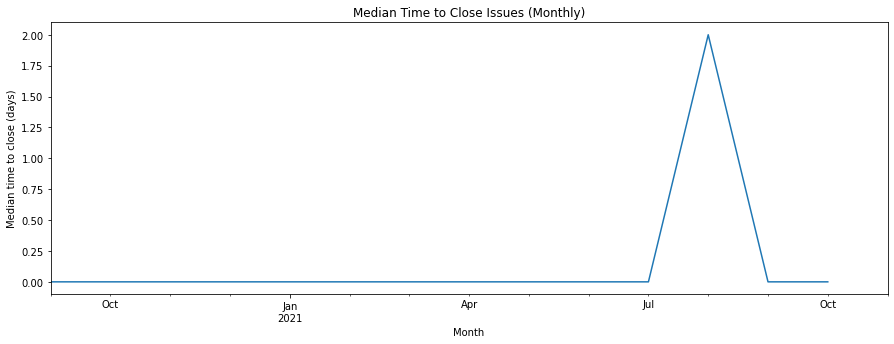

In [14]:
df_issues_closed_monthly_days.plot()
plt.xlabel("Month")
plt.ylabel("Median time to close (days)")
plt.title("Median Time to Close Issues (Monthly)")
plt.show()

Issues can be closed within seconds/minutes/hours/days, hence making it important to consider all possible time units for better visualizations. We can further expand the above line graph by plotting a bar graph with the normalized log values.

## Bar Plot

Let's plot the bar graph for different time granularity levels by considering the normalized log values to attain a better perspective.

#### Median Time in Days

Text(0.5, 1.0, 'Median Time to Close Issues (Monthly)')

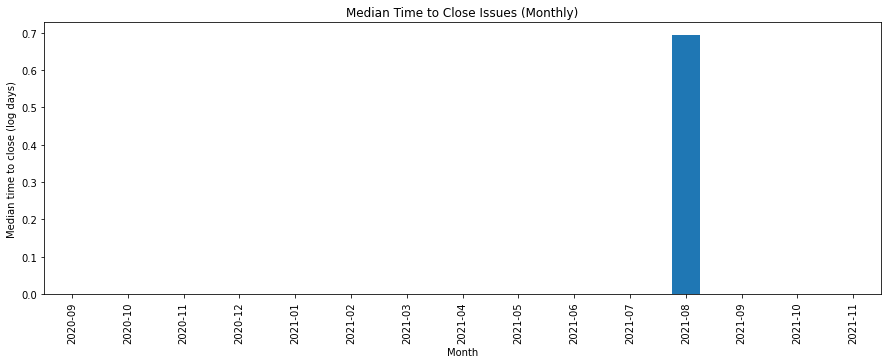

In [15]:
# Plot the normalized log values
df_issues_closed_monthly_days_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Median time to close (log days)")
plt.title("Median Time to Close Issues (Monthly)")

From the above graph we see that there are a few missing values which can be misleading, hence its worthwhile to explore the median time in other time units such as hours, seconds or minutes.

#### Median Time in Hours

Text(0.5, 1.0, 'Median Time to Close Issues (Monthly)')

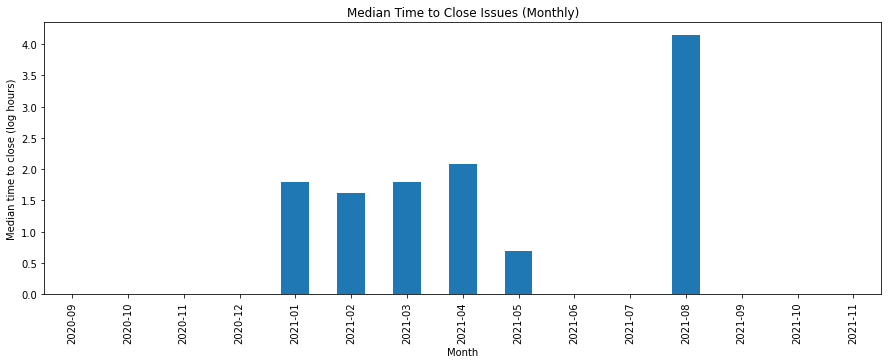

In [16]:
# Plot the normalized log values
df_issues_closed_monthly_hours_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Median time to close (log hours)")
plt.title("Median Time to Close Issues (Monthly)")

#### Median Time in Minutes

Text(0.5, 1.0, 'Median Time to Close Issues (Monthly)')

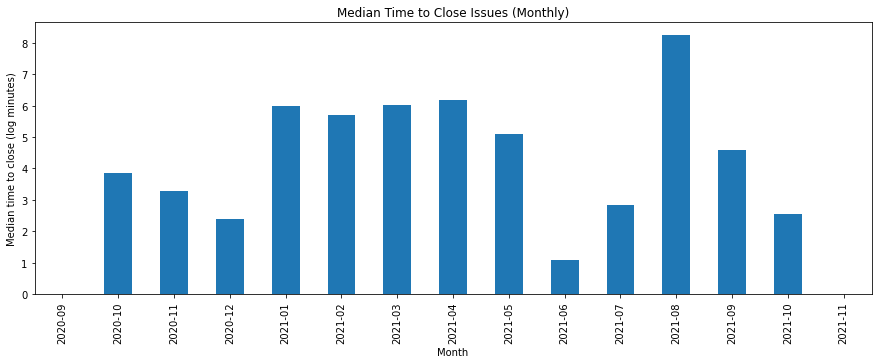

In [17]:
# Plot the normalized log values
df_issues_closed_monthly_minutes_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Median time to close (log minutes)")
plt.title("Median Time to Close Issues (Monthly)")

#### Median Time in Seconds

Text(0.5, 1.0, 'Median Time to Close Issues (Monthly)')

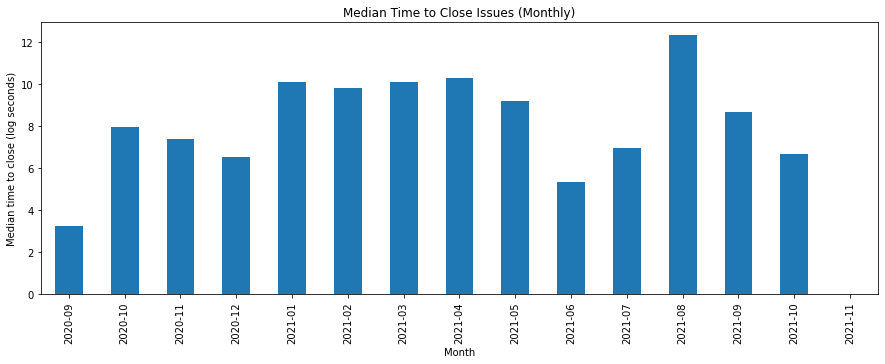

In [18]:
# Plot the normalized log values
df_issues_closed_monthly_seconds_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Median time to close (log seconds)")
plt.title("Median Time to Close Issues (Monthly)")

In [19]:
df_issues_focus['time_to_close'].describe()

count                           570
mean     10 days 20:02:21.998245614
std      36 days 02:21:20.017071111
min                 0 days 00:00:07
25%          0 days 00:08:53.750000
50%          0 days 00:46:20.500000
75%          1 days 16:57:16.250000
max               242 days 19:43:39
Name: time_to_close, dtype: object

## Number of Issues Open
Let's now identify the issues which are still open and view them by the month they were opened originally

In [20]:
df_issues_open = df_issues_focus[df_issues_focus['closed'].isnull()]

In [21]:
df_issues_open = df_issues_open.reset_index(drop=True)

To find out how long an issue has been open, we can find the difference between the current timestamp and the issue creation timestamp

In [22]:
#Calculate the time an issue has been open
df_issues_open['time_open'] = (pd.Timestamp.now() - df_issues_open.created)

In [23]:
df_issues_open['time_open'].describe()

count                             51
mean     256 days 20:25:06.153610724
std         137 days 09:13:18.163235
min           4 days 08:26:40.369297
25%         131 days 00:53:14.369297
50%         329 days 12:37:38.369297
75%         369 days 08:30:41.869297
max         399 days 10:34:01.369297
Name: time_open, dtype: object

Now, lets see the median time issues were open by month

In [24]:
df_issues_open_monthly = df_issues_open['created'].groupby(df_issues_open.created.dt.to_period("M")).agg('count')

We can visualize the median time issues are open with a bar graph

### Monthly Issues Open

Let's plot the number of issues currently open by created months.

Text(0, 0.5, 'Number of Issues')

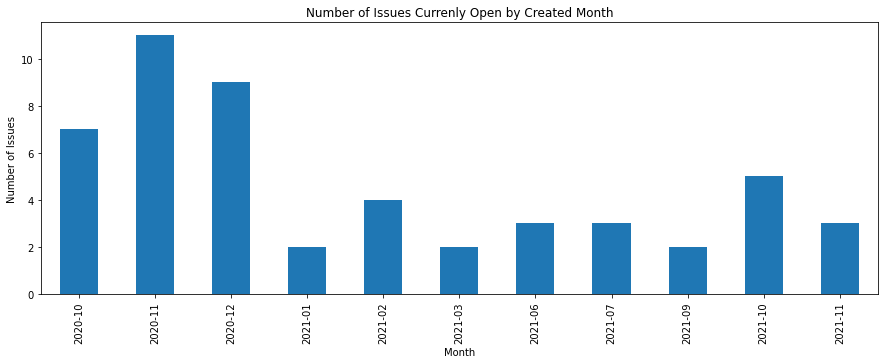

In [25]:
df_issues_open_monthly.plot.bar()
plt.title("Number of Issues Currenly Open by Created Month")
plt.xlabel("Month")
plt.ylabel("Number of Issues")

From the above graph we see that for the `augur` repo, the months of July and August 2021 had the highest number of open issues.

## Time to First Response Issues

Let's now identify the time taken for first responses in issues.

In [26]:
df_issues_comments_focus = df_issues_comments[df_issues_comments['repo_name'] == repo_focus]
df_issues_comments_focus = df_issues_comments_focus.sort_values(by= "msg_time")
df_issues_comments_focus = df_issues_comments_focus.reset_index(drop=True)
df_issues_comments_focus = df_issues_comments_focus.drop_duplicates(subset='issue_id', keep='first')

In [27]:
not_answered = df_issues_focus.shape[0]-df_issues_comments_focus.shape[0]
answered = df_issues_comments_focus.shape[0]

### Pie Chart-Response Percent

We can visualize the response percentage by plotting a pie chart.

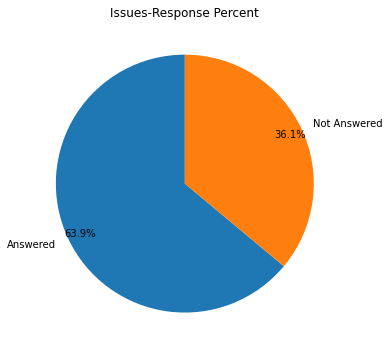

In [28]:
labels = ["Answered","Not Answered"]
sizes = [answered,not_answered]
plt.pie(sizes,autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Issues-Response Percent")
plt.tight_layout()
plt.show()

From the above pie chart, we see that ~54% of the issues response in the `augur` repo were not answered.

### Pie Chart: Bot Percent

We can visualize the amount of first resopnses by bots by plotting a pie chart. There is not a direct way of doing this so we are taking the time of how quickly bots normally respond to a issue. This is a naive approach and will be iterated on

In [29]:
df_issues_comments_focus['time_to_response'] = (df_issues_comments_focus.msg_time - df_issues_comments_focus.created_at)
#df_issues_comments_focus = df_issues_comments_focus[df_issues_comments_focus['time_to_response'] >= pd.Timedelta(0)]

In [30]:
df_issues_bot = df_issues_comments_focus[df_issues_comments_focus['time_to_response'] <= pd.Timedelta(21,unit='m')]

In [31]:
people = df_issues_comments_focus.shape[0]-df_issues_bot.shape[0]
bots = df_issues_bot.shape[0]

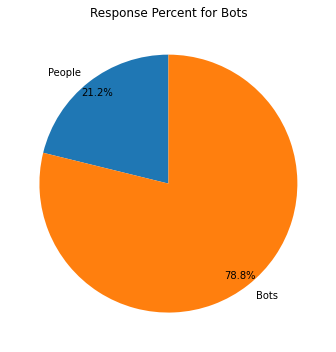

In [32]:
labels = ["People","Bots"]
sizes = [people,bots]
plt.pie(sizes,autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Response Percent for Bots")
plt.tight_layout()
plt.show()

### Bar Plot- Mean Time to First Reponse
***Note: this is the time for only the issues that have a response***

In [33]:
df_issues_comments_monthly = df_issues_comments_focus['time_to_response'].groupby(df_issues_comments_focus.created_at.dt.to_period("M")).agg('mean')

#### Time Granularity and Normalization

We can visualize the trend in median time of first response by month. However, in order to best capture all the median values including the outliers we can normalize the data by taking the `log` of the values before plotting. We should also consider the level of granularity we would like to capture and visualize the median time in i.e. days vs hours vs minutes vs seconds.

Let us first consider the different levels of granularity for the mean time to first response.

In [34]:
# days
df_issues_comments_monthly_days = df_issues_comments_monthly.astype('timedelta64[D]')
# hours
df_issues_comments_monthly_hours = df_issues_comments_monthly.astype('timedelta64[h]')
# minutes
df_issues_comments_monthly_minutes = df_issues_comments_monthly.astype('timedelta64[m]')
# seconds
df_issues_comments_monthly_seconds = df_issues_comments_monthly.astype('timedelta64[s]')

We can now proceed to normalizing the values

In [35]:
df_issues_comments_monthly_days_norm = np.log(df_issues_comments_monthly_days)
df_issues_comments_monthly_hours_norm = np.log(df_issues_comments_monthly_hours)
df_issues_comments_monthly_minutes_norm = np.log(df_issues_comments_monthly_minutes)
df_issues_comments_monthly_seconds_norm = np.log(df_issues_comments_monthly_seconds)

We will now consider the different granularity levels of time i.e. days, hours, minutes and seconds and plot the mean time to first response grouped by months.

#### Mean Time in Days

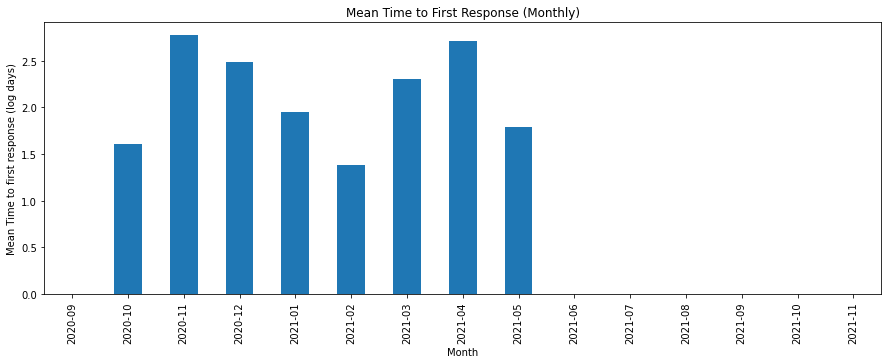

In [36]:
df_issues_comments_monthly_days_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Mean Time to first response (log days)")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

From the above graph we see that there are a few missing values which can be misleading, hence its worthwhile to explore the mean time in other time units such as hours, seconds or minutes.

#### Mean Time in Hours

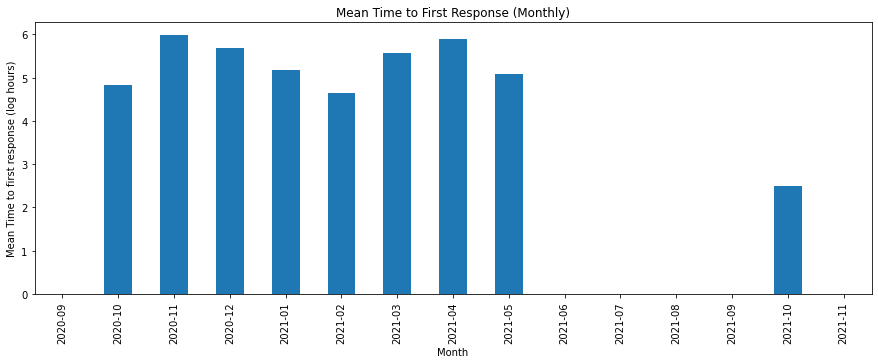

In [37]:
df_issues_comments_monthly_hours_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Mean Time to first response (log hours)")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

#### Mean Time in Minutes

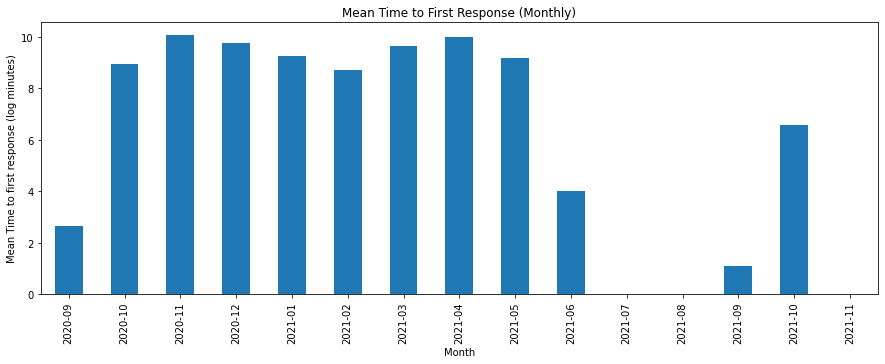

In [38]:
df_issues_comments_monthly_minutes_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Mean Time to first response (log minutes)")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

#### Mean Time in Seconds

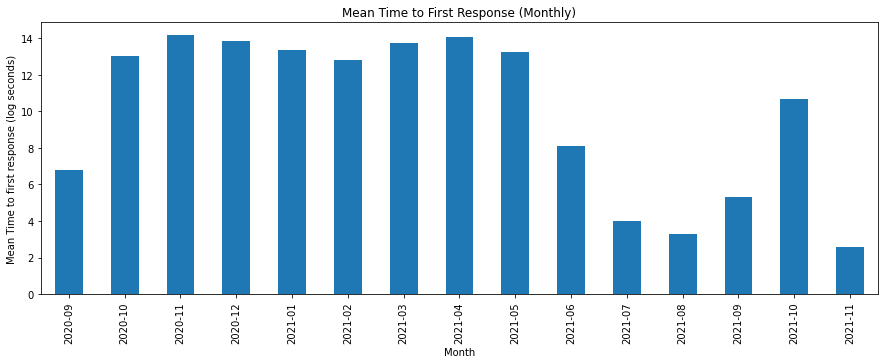

In [39]:
df_issues_comments_monthly_seconds_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Mean Time to first response (log seconds)")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

In [40]:
df_issues_comments_focus.describe()

,issue_id,issue_msg_ref_id,time_to_response
count,397.000000,397.000000,397
mean,68000.428212,60949.886650,7 days 23:46:38.027707808
std,179.250820,409.721585,32 days 23:57:00.037846367
min,67722.000000,60244.000000,0 days 00:00:06
25%,67845.000000,60606.000000,0 days 00:00:14
50%,67980.000000,60908.000000,0 days 00:00:35
75%,68154.000000,61306.000000,0 days 00:18:09
max,68333.000000,61719.000000,253 days 03:36:58


## Conclusion

In this notebook we have visualized some of the performance metrics measured for GitHub issues and considered different time granularity levels such as days, hours, minutes and seconds to gain a better understanding of the metrics behavior.